# this is where I got it from

https://bpostance.github.io/posts/clustering-mixed-data/

In [1]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import preprocessing
from numpy import asarray
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale,RobustScaler,StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from matplotlib import cm
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
import sklearn.metrics as metrics
import sklearn.metrics as metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import ParameterGrid

In [2]:
raw = pd.read_csv('cleaned.csv')
raw.head()

,title,runtime,imdb_score,imdb_votes,user_review_count,critic_review_count,critic_overall_score,critic_positive_score,critic_mixed_score,critic_negative_score,user_overall_score,user_positive_score,user_mixed_score,user_negative_score,#_of_nominations,#_of_wins
0,10,122.0,6.1,17623.0,82.0,51.0,68.0,4.0,1.0,2.0,5.8,3.0,2.0,1.0,2,0
1,12,159.0,7.6,14601.0,42.0,71.0,72.0,12.0,5.0,0.0,7.4,17.0,1.0,3.0,1,0
2,12 Angry Men,96.0,9.0,759612.0,1900.0,150.0,96.0,10.0,0.0,0.0,9.0,484.0,9.0,22.0,3,0
3,12 Monkeys,129.0,8.0,606901.0,722.0,197.0,74.0,16.0,4.0,0.0,8.7,453.0,30.0,12.0,2,0
4,127 Hours,94.0,7.6,369917.0,533.0,453.0,82.0,37.0,1.0,0.0,8.1,621.0,65.0,25.0,6,0


In [3]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
titles = list(raw['title'])
le.fit(titles)
encoded_titles = le.transform(titles)
raw['title'] = encoded_titles

In [4]:
# example of a normalization
from numpy import asarray
from sklearn.preprocessing import MinMaxScaler
columns = ['title','runtime', 'imdb_score', 'imdb_votes', 'user_review_count', 'critic_review_count','critic_overall_score','critic_positive_score','critic_mixed_score','critic_negative_score','user_overall_score','user_positive_score','user_mixed_score','user_negative_score','#_of_nominations','#_of_wins']


In [5]:
# convert numerical-object to numericals
for col in columns:
    raw[col] = raw[col].replace('[^.0-9]', '', regex=True,).astype(float).fillna(0.0)


In [6]:
# clean textual classes
for col in raw.select_dtypes(include='object').columns:
        raw[col] = raw[col].str.upper().replace('Z_','',regex=True).replace('[^A-Z]','',regex=True)

In [7]:
data_types = {f:t for f,t in zip(raw.columns,raw.dtypes)}

In [8]:
# copy df
df = raw.copy()
df = df.drop(labels=['title'],axis=1)
df = df.drop(labels=['#_of_wins'],axis=1)

In [9]:
from sklearn.preprocessing import scale,RobustScaler,StandardScaler, MinMaxScaler

In [10]:
data_meta = pd.DataFrame(df.nunique(),columns=['num'],index=None).sort_values('num').reset_index()
data_meta.columns = ['name','num']
data_meta['type'] = 'numerical'
print(data_meta)

                     name   num       type
0        #_of_nominations    19  numerical
1   critic_negative_score    21  numerical
2      critic_mixed_score    30  numerical
3   critic_positive_score    48  numerical
4              imdb_score    52  numerical
5      user_overall_score    61  numerical
6    critic_overall_score    82  numerical
7                 runtime   132  numerical
8        user_mixed_score   136  numerical
9     user_negative_score   139  numerical
10    critic_review_count   351  numerical
11    user_positive_score   415  numerical
12      user_review_count   585  numerical
13             imdb_votes  1330  numerical


In [11]:
#data_meta.loc[(data_meta['num']<=15) & (~data_meta['name'].isin(['category','name','winner'])),'type']='categorical'
data_meta.loc[data_meta['name'].isin(['category','name']),'type']='categorical'

categorical_features = list(data_meta.loc[data_meta['type']=='categorical','name'])
numerical_features = list(data_meta.loc[data_meta['type']=='numerical','name'])
print(numerical_features)

['#_of_nominations', 'critic_negative_score', 'critic_mixed_score', 'critic_positive_score', 'imdb_score', 'user_overall_score', 'critic_overall_score', 'runtime', 'user_mixed_score', 'user_negative_score', 'critic_review_count', 'user_positive_score', 'user_review_count', 'imdb_votes']


In [12]:
df[numerical_features][:2]

,#_of_nominations,critic_negative_score,critic_mixed_score,critic_positive_score,imdb_score,user_overall_score,critic_overall_score,runtime,user_mixed_score,user_negative_score,critic_review_count,user_positive_score,user_review_count,imdb_votes
0,2.0,2.0,1.0,4.0,6.1,5.8,68.0,122.0,2.0,1.0,51.0,3.0,82.0,17623.0
1,1.0,0.0,5.0,12.0,7.6,7.4,72.0,159.0,1.0,3.0,71.0,17.0,42.0,14601.0


In [13]:
# Standard Scaled "mean normalisation"
scaler = StandardScaler()
scaler.fit(df[numerical_features])
print("Feature Means:\t",[f"{x:.2}" for x in scaler.mean_])
numerical_data = scaler.transform(df[numerical_features])
numerical_data = pd.DataFrame(numerical_data,index=df.index,columns=numerical_features)
numerical_data[:2]

Feature Means:	 ['3.3', '0.88', '4.2', '1.6e+01', '7.3', '6.4', '7.2e+01', '1.2e+02', '2e+01', '1.7e+01', '1.3e+02', '1.7e+02', '3.8e+02', '1.5e+05']


,#_of_nominations,critic_negative_score,critic_mixed_score,critic_positive_score,imdb_score,user_overall_score,critic_overall_score,runtime,user_mixed_score,user_negative_score,critic_review_count,user_positive_score,user_review_count,imdb_votes
0,-0.343712,0.567003,-0.791388,-1.129454,-1.935905,-0.203270,-0.273427,0.150831,-0.449119,-0.353952,-0.715387,-0.435875,-0.545212,-0.516956
1,-0.613511,-0.447414,0.183414,-0.366024,0.439817,0.340819,0.005746,1.744482,-0.473696,-0.309058,-0.525224,-0.398392,-0.618384,-0.528386


In [14]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(df[numerical_features])
numerical_data = scaler.transform(df[numerical_features])
numerical_data = pd.DataFrame(numerical_data,index=df.index,columns=numerical_features)
numerical_data[:2]

,#_of_nominations,critic_negative_score,critic_mixed_score,critic_positive_score,imdb_score,user_overall_score,critic_overall_score,runtime,user_mixed_score,user_negative_score,critic_review_count,user_positive_score,user_review_count,imdb_votes
0,0.013514,0.086957,0.038462,0.088889,0.392157,0.630435,0.619048,0.408163,0.003650,0.00165,0.068571,0.000516,0.010114,0.006858
1,0.000000,0.000000,0.192308,0.266667,0.686275,0.804348,0.666667,0.596939,0.001825,0.00495,0.097143,0.002923,0.005113,0.005667


In [15]:
nominal_features = [c for c in categorical_features]
print("Nominals:\n",nominal_features)

nominal_data = list()
for i,x in df[nominal_features].nunique().iteritems():
    if x <= 2:
        nominal_data.append(pd.get_dummies(df[[i]],drop_first=True))
    elif x > 2:
        nominal_data.append(pd.get_dummies(df[[i]],drop_first=False))
        
#nominal_data = pd.concat(nominal_data,axis=1)

Nominals:
 []


In [16]:
df

,runtime,imdb_score,imdb_votes,user_review_count,critic_review_count,critic_overall_score,critic_positive_score,critic_mixed_score,critic_negative_score,user_overall_score,user_positive_score,user_mixed_score,user_negative_score,#_of_nominations
0,122.0,6.1,17623.0,82.0,51.0,68.0,4.0,1.0,2.0,5.8,3.0,2.0,1.0,2.0
1,159.0,7.6,14601.0,42.0,71.0,72.0,12.0,5.0,0.0,7.4,17.0,1.0,3.0,1.0
2,96.0,9.0,759612.0,1900.0,150.0,96.0,10.0,0.0,0.0,9.0,484.0,9.0,22.0,3.0
3,129.0,8.0,606901.0,722.0,197.0,74.0,16.0,4.0,0.0,8.7,453.0,30.0,12.0,2.0
4,94.0,7.6,369917.0,533.0,453.0,82.0,37.0,1.0,0.0,8.1,621.0,65.0,25.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1331,100.0,7.5,8171.0,173.0,67.0,91.0,6.0,1.0,0.0,8.0,5.0,1.0,0.0,1.0
1332,109.0,6.8,20950.0,111.0,81.0,65.0,9.0,6.0,0.0,7.4,7.0,2.0,0.0,1.0
1333,127.0,8.2,28010.0,117.0,85.0,86.0,18.0,1.0,0.0,7.0,6.0,2.0,2.0,5.0
1334,150.0,7.6,3541.0,36.0,25.0,66.0,16.0,4.0,0.0,7.5,7.0,4.0,0.0,1.0


In [17]:
# transformed and scaled dataset
Xy_scaled = pd.concat([numerical_data],axis=1)
#print(f'Data min:max {Xy_scaled.min().min(),Xy_scaled.max().max()}')

# original data
Xy_original = df[numerical_features].copy()

In [44]:
#reducing dimension using PCA.
#calculates the % of the data we still have of our original
pca_2 = PCA(n_components=2)
pca_2result=pca_2.fit_transform(Xy_scaled)
print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))
print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))

Explained variation per principal component: [0.44986421 0.19022574]
Cumulative variance explained by 2 principal components: 64.01%


In [45]:
cam2 = pd.DataFrame(pca_2result)

In [39]:
cam2.to_csv('cam5.csv')

In [46]:
# candidate values for our cluster
candidate_values = [5,10,15,20,25]

# instantiating ParameterGrid, pass number of clusters as input
parameter_grid = ParameterGrid({'n_clusters': candidate_values})

Parameter: {'n_clusters': 5} Score 0.4334001270970143
Parameter: {'n_clusters': 10} Score 0.35437473409061515
Parameter: {'n_clusters': 15} Score 0.36138468870411644
Parameter: {'n_clusters': 20} Score 0.3448334276863631
Parameter: {'n_clusters': 25} Score 0.3578000494342776


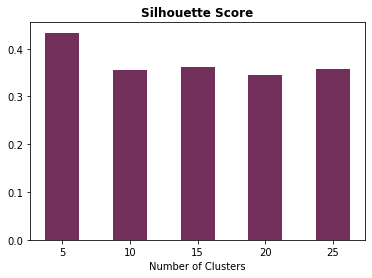

In [47]:
#picking the best K_means model
best_score = -1
kmeans_model = KMeans()     # instantiating KMeans model
silhouette_scores = []

# evaluation based on silhouette_score
for p in parameter_grid:
    kmeans_model.set_params(**p)    # set current hyper parameter
    kmeans_model.fit(pca_2result)         # fit model on wine dataset, this will find clusters based on parameter p
    ss = metrics.silhouette_score(pca_2result, kmeans_model.labels_)   # calculate silhouette_score
    silhouette_scores += [ss]       # store all the scores
    print('Parameter:', p, 'Score', ss)
    # check p which has the best score
    if ss > best_score:
        best_score = ss
        best_grid = p
# plotting silhouette score
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(candidate_values))
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.show()

In [48]:
#We will now apply K-Means
# fitting KMeans    
optimum_num_clusters = 2
kmeans = KMeans(n_clusters= optimum_num_clusters,init="random")
kmeans.fit(pca_2result)

KMeans(init='random', n_clusters=2)

In [43]:
hello = pd.DataFrame(kmeans.labels_)
hello.to_csv('cam6.csv')

In [49]:
Xy_=pca_2result
clusters_ = kmeans.labels_

In [50]:
pred = pd.read_csv('test_data.csv')

titles_pred = list(pred['title'])
le.fit(titles_pred)
titles_pred = le.transform(titles_pred)
pred['title'] = titles_pred


columns_pred = ['title','runtime', 'imdb_score', 'imdb_votes', 'user_review_count', 'critic_review_count','critic_overall_score','critic_positive_score','critic_mixed_score','critic_negative_score','user_overall_score','user_positive_score','user_mixed_score','user_negative_score','#_of_nominations','#_of_wins']


    
for col in columns_pred:
    pred[col] = pred[col].replace('[^.0-9]', '', regex=True,).astype(float).fillna(0.0)

    

for col in pred.select_dtypes(include='object').columns:
        pred[col] = pred[col].str.upper().replace('Z_','',regex=True).replace('[^A-Z]','',regex=True)

dp = pred.copy()
dp = dp.drop(labels=['title'],axis=1)
dp = dp.drop(labels=['#_of_wins'],axis=1)

#print(data_count)
data_count_dp = pd.DataFrame(dp.nunique(),columns=['num'],index=None).sort_values('num').reset_index()
data_count_dp.columns = ['name','num']
data_count_dp['type'] = 'numerical'

#data_count_dp.loc[data_count_dp['name'].isin(['category']),'type']='nominal'

nominal_features_dp = list(data_count_dp.loc[data_count_dp['type']=='nominal','name'])
numerical_features_dp = list(data_count_dp.loc[data_count_dp['type']=='numerical','name'])

scaler_dp = StandardScaler()
scaler_dp.fit(dp[numerical_features_dp])
print("Feature Means:\t",[f"{x:.2}" for x in scaler_dp.mean_])
numerical_data_dp = scaler_dp.transform(dp[numerical_features_dp])
numerical_data_dp = pd.DataFrame(numerical_data_dp,index=dp.index,columns=numerical_features_dp)
numerical_data_dp[:2]

scaler_dp = MinMaxScaler(feature_range=(0,1))
scaler_dp.fit(dp[numerical_features_dp])
numerical_data_dp = scaler_dp.transform(dp[numerical_features_dp])
numerical_data_dp = pd.DataFrame(numerical_data_dp,index=dp.index,columns=numerical_features_dp)


# transformed and scaled dataset
Xy_scaled_dp = pd.concat([numerical_data_dp],axis=1)
print(f'Data min:max {Xy_scaled.min().min(),Xy_scaled.max().max()}')

print(Xy_scaled_dp.shape)
# original data
Xy_original_dp = dp[numerical_features_dp].copy()

column_names_dp = Xy_scaled_dp.columns.values
column_names_dp.shape

Feature Means:	 ['1.7', '4.8', '8.0', '4.9', '8.1', '5e+01', '4.1e+01', '7.8e+01', '1.3e+02', '4.2e+05', '1.3e+03', '1.2e+03', '9.1e+01', '8.1e+01']
Data min:max (0.0, 1.0)
(12, 14)


(14,)

In [51]:
#reducing dimension using PCA.
#calculates the % of the data we still have of our original
pca_3 = PCA(n_components=2)
pca_3result=pca_2.fit_transform(Xy_scaled_dp)
print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))
print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))

Explained variation per principal component: [0.48296128 0.26214879]
Cumulative variance explained by 2 principal components: 74.51%


In [52]:
kmeans.labels_

array([1, 1, 1, ..., 1, 1, 1])

In [53]:
kmeans.predict(pca_3result)

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1])

In [54]:
from sklearn.cluster import KMeans
from matplotlib import cm
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

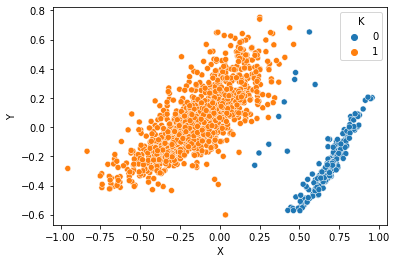

In [55]:
#Xy_,clusters_ = make_blobs(n_samples=4000, centers=5, cluster_std=0.7)
df_ = pd.DataFrame(Xy_,columns=['X','Y'])
df_['K'] = clusters_
sns.scatterplot(x='X',y='Y',hue='K',data=df_);

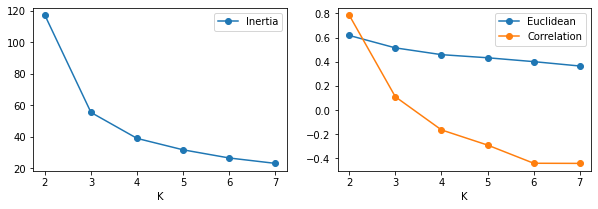

In [56]:
results = dict()
k_cand = [2,3,4,5,6,7] #

for k in k_cand:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Xy_)
    score0 = kmeans.inertia_
    score1 = silhouette_score(Xy_,kmeans.labels_,metric='euclidean')
    score2 = silhouette_score(Xy_,kmeans.labels_,metric='correlation')
    results[k] = {'k':kmeans,'s0':score0,'s1':score1,'s2':score2}

fig,axs = plt.subplots(1,2,sharex=True,figsize=(10,3))
axs[0].plot([i for i in results.keys()],[i['s0'] for i in results.values()],'o-',label='Inertia')
axs[1].plot([i for i in results.keys()],[i['s1'] for i in results.values()],'o-',label='Euclidean')
axs[1].plot([i for i in results.keys()],[i['s2'] for i in results.values()],'o-',label='Correlation')
for ax in axs:
    ax.set_xticks(k_cand)
    ax.set_xlabel('K')
    ax.legend()

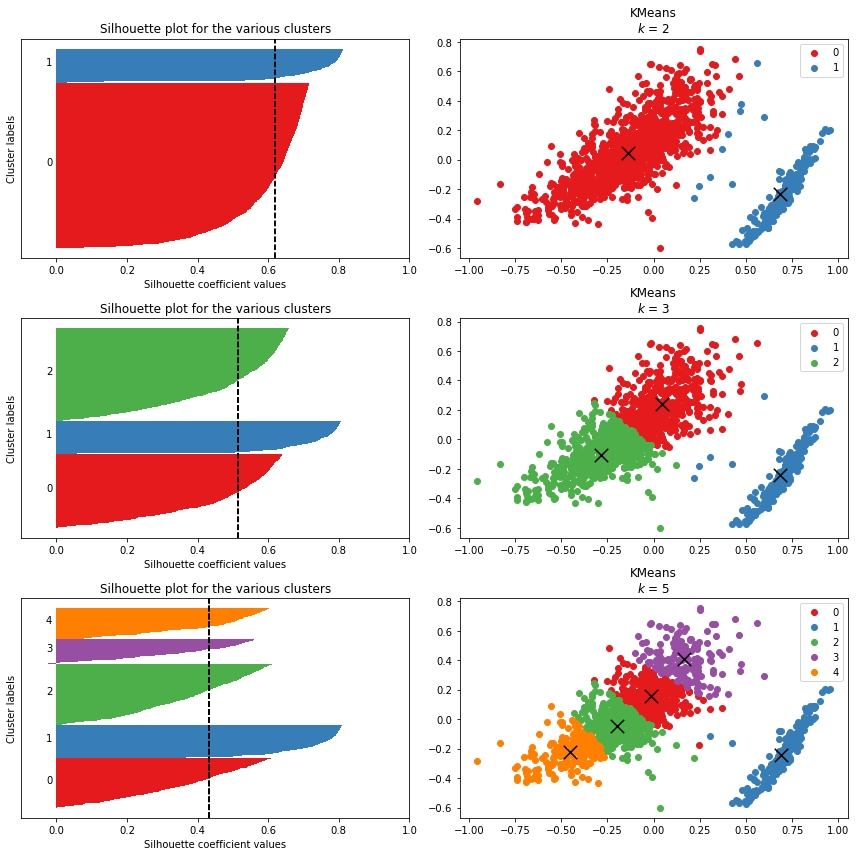

In [57]:
k_cand = [2,3,5]

fig,axs = plt.subplots(len(k_cand),2,figsize=(12,12))

for e,k in enumerate(k_cand):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Xy_)
    
    cdict = {i:cm.Set1(i) for i in np.unique(kmeans.labels_)}
    
    ## silhouette samples
    silhouette_vals = silhouette_samples(Xy_,kmeans.labels_)
    y_lower = 0 
    y_upper = 0
    for i,cluster in enumerate(np.unique(kmeans.labels_)):
        cluster_silhouette_vals = silhouette_vals[kmeans.labels_==cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        axs[e,0].barh(range(y_lower,y_upper),
                      cluster_silhouette_vals,
                      height=1,
                      color=cdict[cluster])
        axs[e,0].text(-0.03,(y_lower+y_upper)/2,str(i))
        
        y_lower += len(cluster_silhouette_vals) # add for next iteration 
        avg_score = np.mean(silhouette_vals)
        axs[e,0].axvline(avg_score,linestyle ='--',color = 'black')
        
        axs[e,0].set_yticks([])
        axs[e,0].set_xlim([-0.1, 1])
        axs[e,0].set_xlabel('Silhouette coefficient values')
        axs[e,0].set_ylabel('Cluster labels')
        axs[e,0].set_title('Silhouette plot for the various clusters')
        
    ## plot data and cluster centroids
    results = pd.DataFrame(Xy_)
    results['k'] = kmeans.labels_
    for cluster in np.unique(kmeans.labels_): # plot data by cluster
        axs[e,1].scatter(x=results.where(results['k']==cluster)[0],
                         y=results.where(results['k']==cluster)[1],
                         color=cdict[cluster],
                         label=cluster)
    # plot centroids
    axs[e,1].scatter(x=kmeans.cluster_centers_[:,0],
                     y=kmeans.cluster_centers_[:,1],
                     marker='x',color='black',s=180)
    axs[e,1].legend(bbox_to_anchor=(1,1))
    axs[e,1].set_title(f"KMeans\n$k$ = {k}")
    plt.tight_layout()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1336 samples in 0.002s...
[t-SNE] Computed neighbors for 1336 samples in 0.040s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1336
[t-SNE] Computed conditional probabilities for sample 1336 / 1336
[t-SNE] Mean sigma: 0.033633
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.146351
[t-SNE] KL divergence after 500 iterations: 0.444424


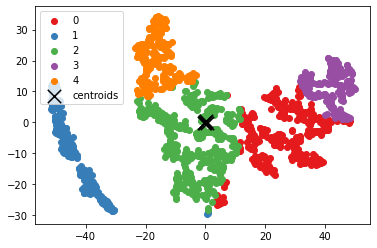

In [59]:
#a,b = make_blobs(n_samples=4000,n_features=5, centers=5, cluster_std=0.7)
a = pca_2result
b = kmeans.labels_

kmeans = KMeans(n_clusters=5, random_state=0).fit(a)

tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
tsne = tsne_model.fit_transform(a)
tsne = pd.DataFrame(tsne)
tsne['k'] = kmeans.labels_

for cluster in np.unique(kmeans.labels_): # plot data by cluster
    plt.scatter(x=tsne.where(tsne['k']==cluster)[0],
                y=tsne.where(tsne['k']==cluster)[1],
                color=cdict[cluster],
                label=cluster)

plt.scatter(kmeans.cluster_centers_[:,0],
            kmeans.cluster_centers_[:,1],
            marker='x',color='black',s=180,
            label='centroids')
plt.legend();

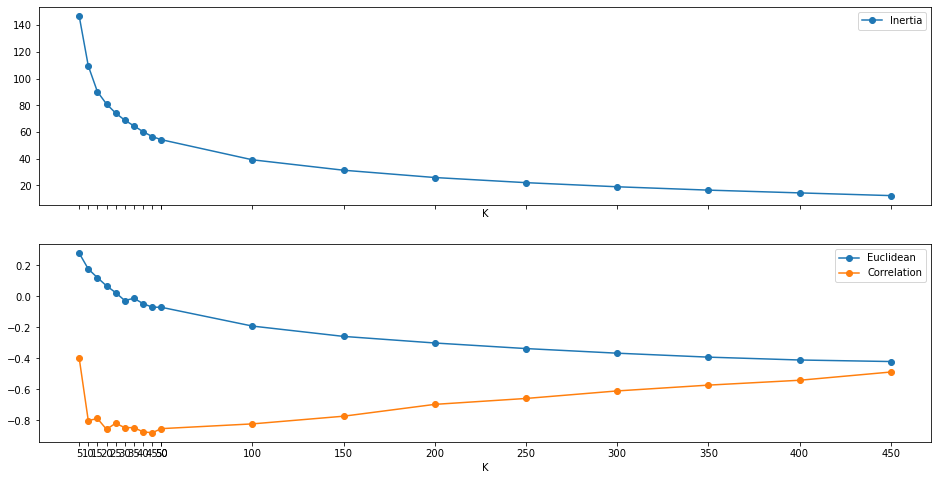

In [61]:
results = dict()
k_cand = list(np.arange(5,55,5))
k_cand.extend(list(np.arange(50,500,50)))
#print(k_cand)

for k in k_cand:
    #print(k)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Xy_scaled)
    score0 = kmeans.inertia_
    score1 = silhouette_score(Xy_,kmeans.labels_,metric='euclidean')
    score2 = silhouette_score(Xy_,kmeans.labels_,metric='correlation')
    results[k] = {'k':kmeans,'s0':score0,'s1':score1,'s2':score2}
    #print(k)

fig,axs = plt.subplots(2,1,sharex=True,figsize=(16,8))
axs[0].plot([i for i in results.keys()],[i['s0'] for i in results.values()],'o-',label='Inertia')
axs[1].plot([i for i in results.keys()],[i['s1'] for i in results.values()],'o-',label='Euclidean')
axs[1].plot([i for i in results.keys()],[i['s2'] for i in results.values()],'o-',label='Correlation')
for ax in axs:
    ax.set_xticks(k_cand)
    ax.set_xlabel('K')
    ax.legend()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1336 samples in 0.001s...
[t-SNE] Computed neighbors for 1336 samples in 0.022s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1336
[t-SNE] Computed conditional probabilities for sample 1336 / 1336
[t-SNE] Mean sigma: 0.033633
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.146351
[t-SNE] KL divergence after 500 iterations: 0.444424


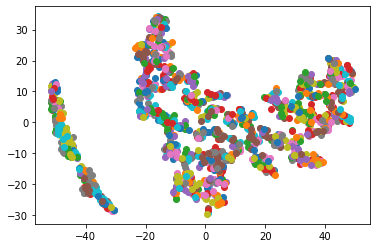

In [62]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
tsne = tsne_model.fit_transform(pca_2result)
tsne = pd.DataFrame(tsne)
tsne['k'] = results[400]['k'].labels_

for cluster in np.unique(kmeans.labels_): # plot data by cluster
    plt.scatter(x=tsne.where(tsne['k']==cluster)[0],
                y=tsne.where(tsne['k']==cluster)[1]
               )

In [63]:
from pyclustering.cluster.kmedoids import kmedoids
from scipy.spatial.distance import pdist,squareform

Wall time: 13.9 s


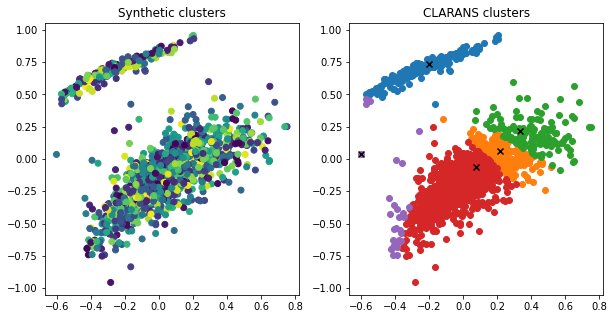

In [66]:
from pyclustering.cluster.clarans import clarans
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# synthetic clusters
#I,c = make_blobs(10302,n_features=36,centers=5)

I = pca_2result
c = kmeans.labels_


# implement clarans
clarans_instance = clarans(I.tolist(), 5, 2, 4);
%time clarans_instance.process()
clusters = clarans_instance.get_clusters()
medoids = clarans_instance.get_medoids()

fig,axs=plt.subplots(1,2,figsize=(10,5))
axs[0].scatter(I[:,1],I[:,0],c=c)
axs[0].set_title('Synthetic clusters')
axs[1].set_title('CLARANS clusters')
for c_,m in zip(clusters,medoids):
    axs[1].scatter(I[c_,1],I[c_,0])
    axs[1].scatter(I[m,1],I[m,0],marker='x',c='black',label='medoids')

In [70]:
import sys
!{sys.executable} -m pip install gower
import gower

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for gower: filename=gower-0.0.5-py3-none-any.whl size=4231 sha256=0919f61daab4d5bd62580ddaa3a5678017885a8555417c5349627c35ce17e81f
  Stored in directory: c:\users\kjcox\appdata\local\pip\cache\wheels\0e\4a\62\f296d39ee4f9ffc44a8d44413dc8ce99ed022c581352312c20
Successfully built gower


In [82]:
cat = [True if x in categorical_features else False for x in Xy_original.columns]

n = 5
focus = Xy_original.sample(1)
similar = gower.gower_topn(focus,Xy_original,
                           n=n,cat_features=cat)

In [83]:
print(similar['values'])
Xy_original.iloc[similar['index']]

[0.         0.03720029 0.03953135 0.0411377  0.04143577]


,#_of_nominations,critic_negative_score,critic_mixed_score,critic_positive_score,imdb_score,user_overall_score,critic_overall_score,runtime,user_mixed_score,user_negative_score,critic_review_count,user_positive_score,user_review_count,imdb_votes
559,4.0,0.0,2.0,34.0,7.8,7.5,80.0,101.0,51.0,100.0,244.0,535.0,1000.0,467891.0
947,3.0,0.0,2.0,36.0,8.0,7.6,85.0,115.0,66.0,121.0,328.0,712.0,944.0,626136.0
569,4.0,0.0,2.0,42.0,7.7,7.5,89.0,102.0,66.0,105.0,287.0,605.0,2000.0,443262.0
613,1.0,0.0,3.0,34.0,7.7,7.1,80.0,145.0,44.0,60.0,260.0,361.0,1400.0,538419.0
8,2.0,0.0,2.0,35.0,7.7,7.3,76.0,122.0,68.0,49.0,304.0,362.0,680.0,305208.0


In [84]:
# create list of cat_feature indicator
cat = [True if x in categorical_features else False for x in Xy_original.columns]

%time gd = gower.gower_matrix(Xy_original, cat_features=cat)

Wall time: 155 ms


In [85]:
print(f"Data shape: {Xy_original.shape}\nMatrix shape: {gd.shape}")
pd.DataFrame(gd[:3,:3])

Data shape: (1336, 14)
Matrix shape: (1336, 1336)


,0,1,2
0,0.000000,0.084201,0.174706
1,0.084201,0.000000,0.148876
2,0.174706,0.148876,0.000000


In [75]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

In [78]:
# condensed matrix
#gdv = squareform(gd,force='tovector')

# output matrix has format [idx1, idx2, dist, sample_count]
Z = linkage(Xy_,method='complete')
Z_df = pd.DataFrame(Z,columns=['id1','id2','dist','n'])
Z_df[:2]

,id1,id2,dist,n
0,697.0,1142.0,0.000387,2.0
1,377.0,1303.0,0.000505,2.0


Leaves = 62


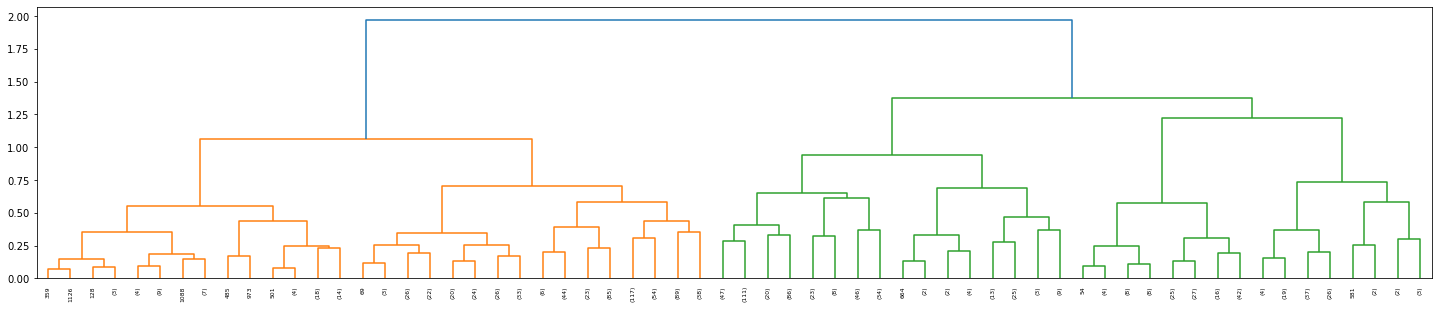

In [80]:
fig,axs = plt.subplots(1,1,figsize=(25,5))
dn = dendrogram(Z, truncate_mode='level',p=5,show_leaf_counts=True,ax=axs);
print(f"Leaves = {len(dn['leaves'])}")

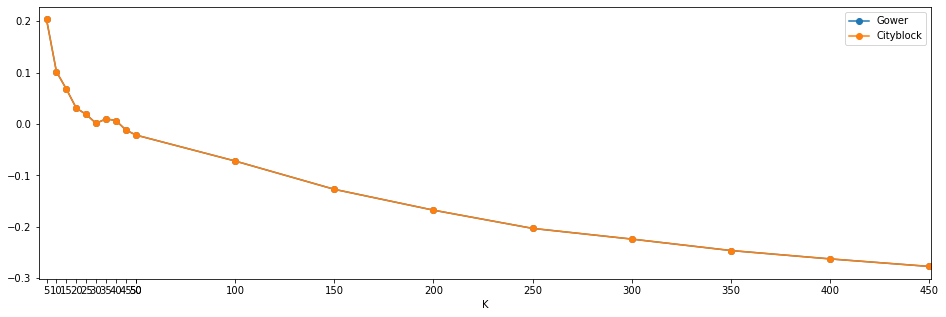

In [87]:
# find k clusters
results = dict()
k_cand = list(np.arange(5,55,5))
k_cand.extend(list(np.arange(50,500,50)))

for k in k_cand:
    #print(k)
    cluster_array = fcluster(Z, k, criterion='maxclust')
    score0 = silhouette_score(gd, cluster_array, metric='precomputed')
    score1 = silhouette_score(Xy_scaled, cluster_array,metric='cityblock')
    results[k] = {'k':cluster_array,'s0':score0,'s1':score1}
    
fig,axs = plt.subplots(1,1,figsize=(16,5))
axs.plot([i for i in results.keys()],[i['s0'] for i in results.values()],'o-',label='Gower')
axs.plot([i for i in results.keys()],[i['s1'] for i in results.values()],'o-',label='Cityblock')
axs.set_xlim(1,451)
axs.set_xticks(k_cand)
axs.set_xlabel('K')
axs.legend();

<AxesSubplot:title={'center':'imdb_score'}, xlabel='k'>

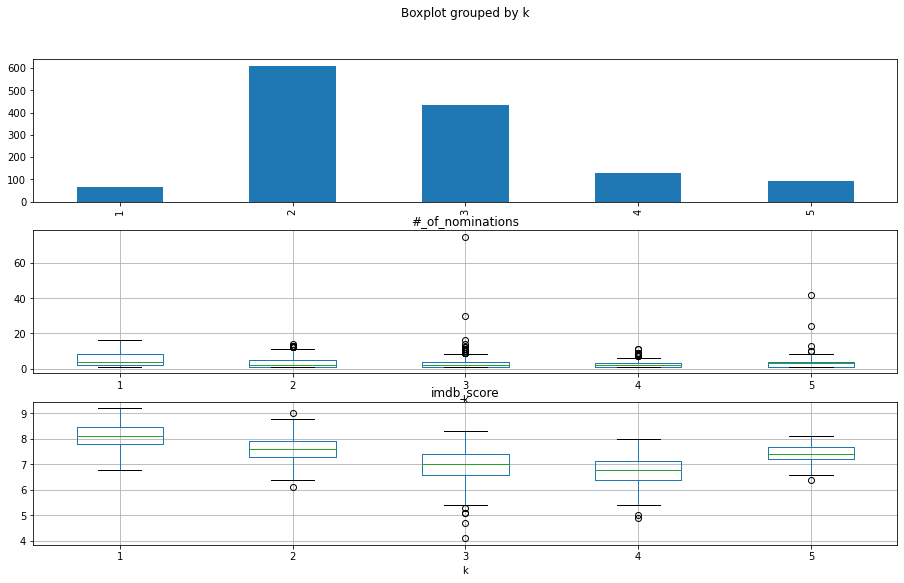

In [90]:
fig,axs = plt.subplots(3,1,figsize=(15,9),sharex=False)
Xy_original['k'] = results[5]['k']

Xy_original['k'].value_counts().sort_index().plot.bar(ax=axs[0])
Xy_original.boxplot(by='k',column='#_of_nominations',ax=axs[1])
Xy_original.boxplot(by='k',column='imdb_score',ax=axs[2])